<a href="https://colab.research.google.com/github/lmassaron/fine-tuning-workshop/blob/main/05_fine_tuning_sentiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fine-tune Gemma 3 1B-IT for Sentiment Analysis

This tutorial covers the **fine-tuning process** of the recently launched **Gemma 3 1B** model for **sentiment analysis** on financial and economic information. Sentiment analysis in this domain is crucial for businesses for several reasons, including:

- **Market Insights**: Gaining valuable insights into market trends, investor confidence, and consumer behavior.  
- **Risk Management**: Identifying potential reputational risks.  
- **Investment Decisions**: Assessing the sentiment of stakeholders, investors, and the general public to evaluate investment opportunities.  

Before diving into the technical aspects of fine-tuning a large language model like **Gemma**, we must first select an appropriate **dataset** to showcase its capabilities.

## Introducing the Gemma 3 1B-IT

**Gemma 3** is Google's latest addition to its family of lightweight, state-of-the-art open AI models, designed to deliver high performance while being resource-efficient. The **1B Instruct** version of **Gemma 3** is tailored for **instruction-based tasks**, offering developers an accessible and powerful tool for creating intelligent applications.  

Announcement: [Gemma 3 Blog Post](https://blog.google/technology/developers/gemma-3/)

Gemma 3 features a **transformer architecture** optimized with advanced techniques, enabling sophisticated reasoning and text generation capabilities.

Key Features:
- **128K-token context window**: Allows processing and understanding of vast amounts of information.  
- **Multilingual support**: Over **140 languages**, ideal for global applications.  
- **Multimodal capabilities**: Supports text, images, and videos, enabling interactive AI solutions.  
- **Edge device optimization**: Efficiently runs on consumer hardware with a single GPU, making it accessible for developers with limited resources.

Resources:
- [Gemma 3 Model Overview](https://ai.google.dev/gemma/docs/core)  
- [Gemma 3 Technical Report](https://storage.googleapis.com/deepmind-media/gemma/Gemma3Report.pdf)  
- [Gemma 3 Model Card](https://ai.google.dev/gemma/docs/core/model_card_3)

## Dataset Selection

Annotated datasets for finance and economic texts are relatively rare, with many being proprietary. To address this challenge, researchers from the **Aalto University School of Business** introduced the **FinancialPhraseBank Dataset** in 2014, which contains approximately **5,000 sentences**.  

This dataset provides **human-annotated benchmarks**, allowing for consistent evaluation of different modeling techniques. The annotations were performed by **16 individuals** with a background in **financial markets**, who categorized the sentences as having a:

- **Positive** impact on stock prices  
- **Negative** impact on stock prices  
- **Neutral** impact on stock prices  

The impact was assessed from an **investor's perspective**.

## More on the FinancialPhraseBank Dataset

The **FinancialPhraseBank** dataset is a comprehensive collection of **financial news headlines** analyzed from the viewpoint of **retail investors**. It includes two key columns:

- **Sentiment**: Classified as **negative**, **neutral**, or **positive**.  
- **News Headline**: The actual **financial news snippet**.

This dataset has been widely used in research, including the study by **Malo, P.**, **Sinha, A.**, **Korhonen, P.**, **Wallenius, J.**, and **Takala, P.**, titled "*Good Debt or Bad Debt: Detecting Semantic Orientations in Economic Texts*" (published in the **Journal of the Association for Information Science and Technology**, 2014).

## Required Libraries

To implement this tutorial, we need to install several essential libraries:

In [1]:
# Check the GPU information
!nvidia-smi

Thu Sep 25 14:13:46 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   72C    P8             11W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
# Install necessary libraries for model training and evaluation
%%capture
!pip install -U transformers trl peft accelerate bitsandbytes

### Explanation of Key Libraries  

- **`transformers`**: Provides a framework to handle **pre-trained NLP models** for tasks like **text classification** and **question answering**.  

- **`accelerate`**: A distributed training library by Hugging Face designed for **parallelizing training** across multiple **GPUs or CPUs**.  

- **`peft`**: A library for **parameter-efficient fine-tuning (PEFT)** of pre-trained language models, including support for **LoRA (Low-Rank Adaptation)**.  

- **`trl`**: A Hugging Face library for training **transformer models** with **supervised fine-tuning** or **reinforcement learning techniques**.  

-   **`bitsandbytes`**: A lightweight library that provides custom CUDA functions for **8-bit and 4-bit quantization** of PyTorch models. This significantly reduces the memory footprint of large language models, making it possible to run them on less powerful hardware. `bitsandbytes` offers features like 8-bit optimizers and 4-bit quantization with QLoRA, which enables training large models with reduced memory requirements without compromising performance.

## Setting Environment Variables

The following code sets environment variables to configure the GPU usage and suppress unnecessary warnings:

In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0" # Use the first GPU
os.environ["TOKENIZERS_PARALLELISM"] = "false" # Disable tokenization parallelism

## Suppressing Warnings

During training, several warnings may appear that do not impact the fine-tuning process but can be distracting. To suppress them:

In [5]:
import warnings
warnings.filterwarnings("ignore")

Global variable for demonstrations

In [4]:
DEMO = False

## Importing Necessary Libraries

The following Python libraries are required for running the fine-tuning process:

In [6]:
import numpy as np
import pandas as pd
import os
from tqdm import tqdm

import torch
import torch.nn as nn

import transformers
from transformers import (AutoModelForCausalLM,
                          AutoTokenizer,
                          BitsAndBytesConfig,
                          TrainingArguments,
                          pipeline,
                          logging)

from transformers.models.gemma3 import Gemma3ForCausalLM

from datasets import Dataset
from peft import LoraConfig, PeftConfig, PeftModel
from trl import SFTTrainer, SFTConfig
import bitsandbytes as bnb

from sklearn.metrics import (accuracy_score,
                             classification_report,
                             confusion_matrix)

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

To check the installed version of the transformers library:

In [7]:
print(f"transformers=={transformers.__version__}")

transformers==4.56.2


This function determines the best computing device for running the tutorial:

In [8]:
def define_device():
    """Determine and return the optimal PyTorch device based on availability."""

    print(f"PyTorch version: {torch.__version__}", end=" -- ")

    # Check if MPS (Metal Performance Shaders) is available for macOS
    if hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
        print("using MPS device on macOS")
        return torch.device("mps")

    # Check for CUDA availability
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"using {device}")
    return device

This code initializes the Gemma 3 1B model for causal language modeling, ensuring optimal settings based on the available hardware.  

* If the GPU supports **bfloat16** (available on GPUs with Compute Capability **8.0+**), it is used for computations.  
  Otherwise, **float16** is used as the default.  

* **Device Selection:**  
  * The function `define_device()` selects the best available device (**CPU, CUDA, or MPS**).  

* **Model Initialization:**  
  * The model is loaded with memory-efficient configurations, including `low_cpu_mem_usage=True`, and assigned to the selected device.  

* **Tokenizer Setup:**  
  * A **tokenizer** is initialized with a **maximum sequence length of 8192**.  
  * The **end-of-sequence (EOS) token** is stored for later use.  

In [9]:
# Determine optimal computation dtype based on GPU capability
compute_dtype = torch.bfloat16 if torch.cuda.get_device_capability()[0] >= 8 else torch.float16
print(f"Using compute dtype {compute_dtype}")

# Select the best available device (CPU, CUDA, or MPS)
device = define_device()
print(f"Operating on {device}")

# Path to the pre-trained model
GEMMA_PATH = "google/gemma-3-1b-it"

# Load the model with optimized settings
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=compute_dtype,
    bnb_4bit_use_double_quant=True,
)

model = Gemma3ForCausalLM.from_pretrained(
    GEMMA_PATH,
    torch_dtype=compute_dtype,
    attn_implementation="eager",
    low_cpu_mem_usage=True,
    quantization_config=quantization_config,
    device_map="auto"
)

# Define maximum sequence length for the tokenizer
max_seq_length = 1024

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained(
    GEMMA_PATH,
    max_seq_length=max_seq_length,
    device_map=device
)

# Store the EOS token for later use
EOS_TOKEN = tokenizer.eos_token

`torch_dtype` is deprecated! Use `dtype` instead!


Using compute dtype torch.float16
PyTorch version: 2.8.0+cu126 -- using cuda
Operating on cuda


In [10]:
print(f"Model: {model.name_or_path}")
print(f"Device: {model.device}")
print(f"DType: {model.dtype}")

if hasattr(model, "is_quantized") and model.is_quantized:
    # The quantization_config attribute holds the BitsAndBytesConfig object
    print("Quantization: Enabled")
    print(f"  - 4bit: {model.is_loaded_in_4bit}")
    print(f"  - Quant Type: {model.hf_quantizer.quantization_config.bnb_4bit_quant_type}")
    print(f"  - Compute DType: {model.hf_quantizer.quantization_config.bnb_4bit_compute_dtype}")
else:
    print("Quantization: Disabled")

Model: google/gemma-3-1b-it
Device: cuda:0
DType: torch.float16
Quantization: Enabled
  - 4bit: True
  - Quant Type: nf4
  - Compute DType: torch.float16


Before proceeding, let's ensures that the entire model is correctly moved to the GPU.


In [11]:
is_on_gpu = all(param.device.type == 'cuda' for param in model.parameters())
print("Model is on GPU:", is_on_gpu)

Model is on GPU: True


The following code prepares the dataset for fine-tuning a sentiment analysis model using Gemma. It follows these steps:  

1. **Load Dataset**  
   * Reads the dataset from `all-data.csv`, which contains two columns:  
     - **sentiment**: The sentiment label (positive, neutral, negative).  
     - **text**: The financial news headlines.  

2. **Stratified Train-Test Split**  
   * The dataset is split into **training** and **test** sets, each containing **300 samples per sentiment class**.  
   * **Stratification** ensures that each set has an equal distribution of positive, neutral, and negative examples.  

3. **Shuffle Training Data**  
   * The training data is shuffled using `random_state=10` to ensure **replicability**.  

4. **Prepare Evaluation Data**  
   * The remaining (unselected) data is assigned to an **evaluation set (`X_eval`)**.  
   * To ensure **balanced evaluation**, each sentiment class is resampled to have **50 instances** (negative samples are duplicated if needed).  

5. **Convert Text into Prompts**  
   * The **training** and **evaluation** data are transformed into **prompts** that instruct the model to classify sentiment.  
   * **Training prompts** include sentiment labels (used for fine-tuning).  
   * **Test prompts** omit sentiment labels (used for inference).  

6. **Wrap Data Using Hugging Face's Dataset Class**  
   * Converts `train_data`, `eval_data`, and `test_data` into **Hugging Face Dataset objects** for compatibility with the training pipeline.

In [12]:
# Load dataset
filename = "https://github.com/lmassaron/Gemma-3-1B-financial-sentiment-analysis/raw/refs/heads/main/all-data.csv"
df = pd.read_csv(filename,
                 names=["sentiment", "text"],
                 encoding="utf-8", encoding_errors="replace")

# Initialize lists for train and test sets
X_train, X_test = [], []

# Stratified train-test split (300 per sentiment)
for sentiment in ["positive", "neutral", "negative"]:
    train, test = train_test_split(df[df.sentiment == sentiment],
                                   train_size=300,
                                   test_size=300,
                                   random_state=42,
                                   stratify=df[df.sentiment == sentiment]["sentiment"])
    X_train.append(train)
    X_test.append(test)

# Combine and shuffle training data
X_train = pd.concat(X_train).sample(frac=1, random_state=10).reset_index(drop=True)
X_test = pd.concat(X_test).reset_index(drop=True)

# Identify indices not included in train or test sets
selected_indices = set(X_train.index) | set(X_test.index)
X_eval = df.loc[~df.index.isin(selected_indices)].copy()

# Resample evaluation data to maintain class balance (50 per class, with replacement for minority class)
X_eval = X_eval.groupby('sentiment', group_keys=False).apply(
    lambda x: x.sample(n=50, random_state=10, replace=True)
).reset_index(drop=True)

In [13]:
# Function to generate training and evaluation prompts
def generate_train_prompt(data_point):
    return f"""
    Analyze the sentiment of the news headline enclosed in square brackets.
    Determine if it is positive, neutral, or negative, and return the corresponding sentiment label:
    "positive", "neutral", or "negative".

    [{data_point["text"]}] = {data_point["sentiment"]}
    """.strip() + EOS_TOKEN

# Function to generate test prompts (without expected answer)
def generate_test_prompt(data_point):
    return f"""
    Analyze the sentiment of the news headline enclosed in square brackets.
    Determine if it is positive, neutral, or negative, and return the corresponding sentiment label:
    "positive", "neutral", or "negative".

    [{data_point["text"]}] =
    """.strip()

In [14]:
# Apply prompt generation to datasets
X_train = pd.DataFrame(X_train.apply(generate_train_prompt, axis=1), columns=["text"])
X_eval = pd.DataFrame(X_eval.apply(generate_train_prompt, axis=1), columns=["text"])

# Store ground truth labels for test data
y_true = X_test["sentiment"]
X_test = pd.DataFrame(X_test.apply(generate_test_prompt, axis=1), columns=["text"])

# Convert to Hugging Face Dataset format
train_data = Dataset.from_pandas(X_train)
eval_data = Dataset.from_pandas(X_eval)

The following function evaluates the performance of our **fine-tuned sentiment analysis model** by performing the following tasks:

**1. Map Sentiment Labels to Numeric Values**
- **Positive** → `2`
- **Neutral** → `1`
- **Negative** → `0`
- Additionally, handles cases where the label is `'none'` by mapping it to **`1 (neutral)`**.

**2. Calculate Overall Accuracy**
- Computes the accuracy of the model predictions (`y_pred`) compared to the actual sentiment labels (`y_true`).

**3. Compute Accuracy for Each Sentiment Label**
- Extracts **accuracy scores** separately for:
  - **Positive**
  - **Neutral**
  - **Negative**

**4. Generate a Classification Report**
- Prints **precision, recall, and F1-score** for each sentiment category.

**5. Compute and Display the Confusion Matrix**
- Displays a **confusion matrix** to show how often the model misclassifies sentiments (e.g., predicting **neutral** instead of **positive**).


In [15]:
def evaluate(y_true, y_pred):
    """Evaluate the fine-tuned sentiment model's performance."""

    # Define sentiment label mapping
    label_mapping = {'positive': 2, 'neutral': 1, 'negative': 0}

    # Convert labels to numeric values
    y_true = np.array([label_mapping.get(label, 1) for label in y_true])
    y_pred = np.array([label_mapping.get(label, 1) for label in y_pred])

    # Calculate overall accuracy
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Overall Accuracy: {accuracy:.3f}')

    # Compute accuracy for each sentiment label
    unique_labels = np.unique(y_true)  # Get unique labels in y_true

    for label in unique_labels:
        label_mask = y_true == label  # Mask to filter specific class
        label_accuracy = accuracy_score(y_true[label_mask], y_pred[label_mask])
        print(f'Accuracy for label {label} ({list(label_mapping.keys())[list(label_mapping.values()).index(label)]}): {label_accuracy:.3f}')

    # Generate classification report
    class_report = classification_report(y_true, y_pred, target_names=label_mapping.keys())
    print('\nClassification Report:\n', class_report)

    # Compute and display confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred, labels=[0, 1, 2])
    print('\nConfusion Matrix:\n', conf_matrix)

The following function predicts the sentiment of news headlines. It takes three arguments:

- **X_test**: A Pandas DataFrame containing the news headlines to be analyzed.
- **model**: The pre-trained **Gemma-3 4B** language model.
- **tokenizer**: The corresponding tokenizer for the **Gemma-3 4B** model.

### **Function Workflow:**
1. **Iterate through each news headline** in `X_test`:
   - Construct a prompt asking the model to analyze the sentiment.
   - Tokenize the input and move it to the appropriate device (GPU/CPU).
   - Generate text using the model and extract the predicted sentiment label.
   - Append the sentiment label to `y_pred`.

2. **Use the `generate()` function** from the Hugging Face Transformers library:
   - `max_new_tokens=5`: Limits the number of generated tokens.
   - `temperature=0.0`: Ensures deterministic output.

3. **Extract the sentiment label** from the generated text:
   - If the text contains "positive", assign the label **positive**.
   - If the text contains "negative", assign the label **negative**.
   - If the text contains "neutral", assign the label **neutral**.
   - If none of these are found, assign **none** as a fallback.

In [16]:
def predict(X_test, model, tokenizer, device=device, max_new_tokens=5, temperature=0.0):
    """Predict the sentiment of news headlines"""

    y_pred = []  # List to store predicted sentiment labels

    # Iterate through each headline in X_test
    for i in tqdm(range(len(X_test)), desc="Predicting Sentiments"):
        prompt = X_test.iloc[i]["text"]  # Extract headline text

        # Tokenize and move input to the appropriate device
        input_ids = tokenizer(prompt, return_tensors="pt").to(device)

        # Generate output from the model
        if temperature > 0:
          params = {"do_sample": True, "temperature": temperature}
        else:
          params = {"do_sample": False}

        outputs = model.generate(**input_ids,
                                 max_new_tokens=max_new_tokens,
                                 **params)

        # Decode the generated output into text
        result = tokenizer.decode(outputs[0], skip_special_tokens=True).strip().lower()
        result = result.split("=")[-1]

        # Extract sentiment from the generated text
        if "positive" in result:
            y_pred.append("positive")
        elif "negative" in result:
            y_pred.append("negative")
        elif "neutral" in result:
            y_pred.append("neutral")
        else:
            y_pred.append("none")  # Fallback to error if no clear sentiment is detected

    return y_pred

At this stage, we are ready to test the **Gemma-3 1B** model on our dataset **without any fine-tuning**. This initial evaluation provides insights into the model's **inherent performance** and helps establish a **baseline** for comparison with future fine-tuned models.

We use the `predict` function to generate sentiment predictions for the test set:

In [17]:
y_pred = predict(X_test, model, tokenizer)

Predicting Sentiments: 100%|██████████| 900/900 [08:44<00:00,  1.71it/s]


In the next step, we evaluate the model's predictions against the true sentiment labels:

In [18]:
evaluate(y_true, y_pred)

Overall Accuracy: 0.444
Accuracy for label 0 (negative): 0.223
Accuracy for label 1 (neutral): 0.200
Accuracy for label 2 (positive): 0.910

Classification Report:
               precision    recall  f1-score   support

    positive       0.85      0.22      0.35       300
     neutral       0.45      0.20      0.28       300
    negative       0.40      0.91      0.55       300

    accuracy                           0.44       900
   macro avg       0.56      0.44      0.39       900
weighted avg       0.56      0.44      0.39       900


Confusion Matrix:
 [[ 67  50 183]
 [  9  60 231]
 [  3  24 273]]


In the next cell, we set everything up for fine-tuning the model. We configure and initialize a **Simple Fine-tuning Trainer (SFTTrainer)** for training the model using the **Parameter-Efficient Fine-Tuning (PEFT)** method. PEFT is efficient because it operates on a reduced number of parameters compared to the model's overall size. This method focuses on refining only a limited set of additional model parameters while keeping the majority of the pre-trained large language model (LLM) parameters fixed, significantly reducing computational and storage expenses. Additionally, PEFT helps mitigate **catastrophic forgetting**, a common issue when fine-tuning LLMs completely.

### PEFTConfig:
The `peft_config` object specifies the parameters for PEFT. The following are some of the most important parameters:

- **lora_alpha**: The learning rate for the LoRA update matrices.
- **lora_dropout**: The dropout probability for the LoRA update matrices.
- **r**: The rank of the LoRA update matrices.
- **bias**: The type of bias to use. Possible values are: `none`, `additive`, and `learned`.
- **task_type**: The task type the model is being trained for. Possible values are `CAUSAL_LM` and `MASKED_LM`.

### TrainingArguments:
The `training_arguments` object specifies the parameters for training the model. The following are some key parameters:

- **output_dir**: Directory where the training logs and checkpoints will be saved.
- **num_train_epochs**: Number of epochs to train the model for.
- **per_device_train_batch_size**: Number of samples in each batch on each device.
- **gradient_accumulation_steps**: Number of batches to accumulate gradients before updating the model parameters.
- **gradient_checkpointing**: Whether to use gradient checkpointing to reduce GPU memory usage.
- **optim**: The optimizer used for training the model.
- **save_steps**: The number of steps after which to save a checkpoint.
- **logging_steps**: The number of steps after which to log the training metrics.
- **learning_rate**: The learning rate for the optimizer.
- **weight_decay**: The weight decay parameter for the optimizer.
- **fp16**: Whether to use 16-bit floating-point precision.
- **bf16**: Whether to use BFloat16 precision.
- **max_grad_norm**: The maximum gradient norm.
- **max_steps**: The maximum number of steps to train the model for.
- **warmup_ratio**: Proportion of training steps to use for warming up the learning rate.
- **group_by_length**: Whether to group the training samples by length.
- **lr_scheduler_type**: The type of learning rate scheduler to use.
- **report_to**: The tools to report the training metrics to.
- **evaluation_strategy**: The strategy for evaluating the model during training.
- **eval_steps**: Number of update steps between evaluations.
- **eval_accumulation_steps**: Number of prediction steps to accumulate before moving the output to CPU.

### SFTTrainer:
The `SFTTrainer` is a custom trainer class from the **TRL** library. It is used to fine-tune large language models using the PEFT method.

The `SFTTrainer` object is initialized with the following arguments:

- **model**: The model to be trained.
- **train_dataset**: The training dataset.
- **eval_dataset**: The evaluation dataset.
- **peft_config**: The PEFT configuration.
- **tokenizer**: The tokenizer to use.
- **args**: The training arguments.
- **dataset_text_field**: The name of the text field in the dataset.
- **packing**: Whether to pack the training samples.
- **max_seq_length**: The maximum sequence length.

Once the `SFTTrainer` object is initialized, it can be used to train the model by calling the `train()` method.

In [19]:
peft_config = LoraConfig(
    lora_alpha=32,
    lora_dropout=0.05,
    r=64,
    bias="none",
    task_type="CAUSAL_LM",
    target_modules="all-linear",
)

training_arguments = SFTConfig(
    output_dir="logs",
    num_train_epochs=3,
    gradient_checkpointing=True,
    gradient_checkpointing_kwargs={"use_reentrant": False},  # Use reentrant checkpointing
    per_device_train_batch_size=1,
    gradient_accumulation_steps=8,
    optim="adamw_torch_fused",  # Use fused AdamW optimizer
    save_steps=50,
    load_best_model_at_end=True,
    logging_steps=25,
    learning_rate=2e-4,
    weight_decay=0.001,
    fp16=True if compute_dtype == torch.float16 else False,  # Use float16 precision
    bf16=True if compute_dtype == torch.bfloat16 else False,  # Use bfloat16 precision
    max_grad_norm=0.3,
    max_steps=-1,
    warmup_ratio=0.03,
    group_by_length=False,
    eval_strategy="steps",
    eval_steps=50,
    eval_accumulation_steps=1,
    lr_scheduler_type="constant",
    report_to="tensorboard",
    max_length=max_seq_length,
    packing=False,
    dataset_kwargs={
        "add_special_tokens": False,  # Template with special tokens
        "append_concat_token": True,  # Add EOS token as separator token
    }
)

model.config.use_cache = False
model.config.pretraining_tp = 1

trainer = SFTTrainer(
    model=model,
    train_dataset=train_data,
    eval_dataset=eval_data,
    peft_config=peft_config,
    processing_class=tokenizer,
    args=training_arguments,
)

Adding EOS to train dataset:   0%|          | 0/900 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/900 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/900 [00:00<?, ? examples/s]

Adding EOS to eval dataset:   0%|          | 0/150 [00:00<?, ? examples/s]

Tokenizing eval dataset:   0%|          | 0/150 [00:00<?, ? examples/s]

Truncating eval dataset:   0%|          | 0/150 [00:00<?, ? examples/s]

The `trainer.train()` function is called to start the training process. This triggers the fine-tuning of the model based on the specified training arguments, datasets, and PEFT configuration. During this process, the model will iteratively adjust its parameters, leveraging the training data to improve performance on the sentiment analysis task. The training will proceed according to the parameters set in the `training_arguments`, such as the number of epochs, batch size, and evaluation steps.

This method will also handle the evaluation of the model at specified intervals, providing insights into the model's performance as it trains.

In [20]:
# Train model
trainer.train()

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 1}.


Step,Training Loss,Validation Loss,Entropy,Num Tokens,Mean Token Accuracy
112,1.169400,1.123418,1.226791,76027.000000,0.779498
224,0.904200,1.048816,1.031330,151751.000000,0.797315
336,0.675600,1.056400,0.842956,227286.000000,0.803931
448,0.456200,1.182196,0.651138,303036.000000,0.808827


TrainOutput(global_step=452, training_loss=0.8417357293377935, metrics={'train_runtime': 2601.3153, 'train_samples_per_second': 1.384, 'train_steps_per_second': 0.174, 'total_flos': 1374120915996672.0, 'train_loss': 0.8417357293377935, 'epoch': 4.0})

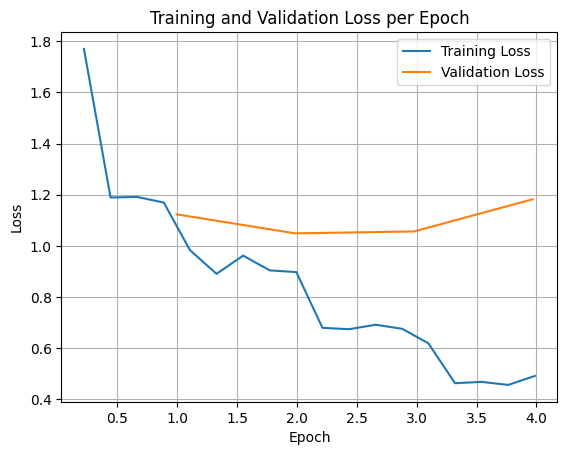

In [21]:
# Access the log history
log_history = trainer.state.log_history

# Extract training / validation loss
train_losses = [log["loss"] for log in log_history if "loss" in log]
epoch_train = [log["epoch"] for log in log_history if "loss" in log]
eval_losses = [log["eval_loss"] for log in log_history if "eval_loss" in log]
epoch_eval = [log["epoch"] for log in log_history if "eval_loss" in log]

# Plot the training loss
plt.plot(epoch_train, train_losses, label="Training Loss")
plt.plot(epoch_eval, eval_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss per Epoch")
plt.legend()
plt.grid(True)
plt.show()

The code below saves the fine-tuned LoRA adapter and tokenizer to a specified directory for later use.

1. **Save the LoRA adapter**:  
   The `trainer.model.save_pretrained(lora_directory)` function saves the trained model (with the LoRA adapter applied) to the directory specified by `lora_directory` ("LoRA-Gemma3-model"). This allows you to reload and use the fine-tuned model later without needing to retrain it.

2. **Save the tokenizer**:  
   The `trainer.tokenizer.save_pretrained(lora_directory)` function saves the tokenizer used during training to the same directory. This ensures that the tokenizer is consistent with the fine-tuned model, enabling you to process text in the same way during inference or further training.

In [22]:
# Save trained LoRA adapter and the tokenizer
trainer.model.save_pretrained("qlora-Gemma3-model")
tokenizer.save_pretrained("qlora-Gemma3-model")

('qlora-Gemma3-model/tokenizer_config.json',
 'qlora-Gemma3-model/special_tokens_map.json',
 'qlora-Gemma3-model/chat_template.jinja',
 'qlora-Gemma3-model/tokenizer.model',
 'qlora-Gemma3-model/added_tokens.json',
 'qlora-Gemma3-model/tokenizer.json')

In [23]:
if not DEMO:
  repo_name = f"lmassaron/qlora4b-Gemma3-1B-finsent"

  # Push the model to the Hub
  trainer.model.push_to_hub(repo_name)

  # Push the tokenizer to the Hub
  tokenizer.push_to_hub(repo_name)

  print(f"Model and tokenizer pushed to {repo_name}")

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...adapter_model.safetensors:   0%|          | 30.0kB /  209MB            

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...plouz1q1i/tokenizer.model: 100%|##########| 4.69MB / 4.69MB            

  ...mplouz1q1i/tokenizer.json:  75%|#######5  | 25.2MB / 33.4MB            

No files have been modified since last commit. Skipping to prevent empty commit.


Model and tokenizer pushed to lmassaron/qlora4b-Gemma3-1B-finsent


The following code performs sentiment label prediction on the test set and evaluates the model's performance:

1. **Predict Sentiment Labels**:  
   The `predict(X_test, model, tokenizer)` function is called to predict the sentiment labels for the test dataset (`X_test`). This function generates predictions based on the fine-tuned model.

2. **Evaluate Model Performance**:  
   The `evaluate(y_true, y_pred)` function is used to assess the model's performance by comparing the true sentiment labels (`y_true`) with the predicted labels (`y_pred`). The evaluation will compute metrics like accuracy, precision, recall, and F1-score, which provide insights into how well the model is performing for each sentiment class.

With a well-fine-tuned model, we expect to achieve an overall accuracy of over 0.8, and the performance for individual sentiment labels (positive, negative, and neutral) should be high, especially for positive and negative classes. While there might still be room for improvement in predicting neutral sentiment, the results should be impressive given the relatively small dataset and the use of fine-tuning.

In [24]:
model.eval()
y_pred = predict(X_test, model, tokenizer)
evaluate(y_true, y_pred)

Predicting Sentiments: 100%|██████████| 900/900 [04:54<00:00,  3.05it/s]

Overall Accuracy: 0.849
Accuracy for label 0 (negative): 0.973
Accuracy for label 1 (neutral): 0.807
Accuracy for label 2 (positive): 0.767

Classification Report:
               precision    recall  f1-score   support

    positive       0.91      0.97      0.94       300
     neutral       0.78      0.81      0.79       300
    negative       0.86      0.77      0.81       300

    accuracy                           0.85       900
   macro avg       0.85      0.85      0.85       900
weighted avg       0.85      0.85      0.85       900


Confusion Matrix:
 [[292   7   1]
 [ 21 242  37]
 [  9  61 230]]


The model performs particularly well with the **negative class** (high recall), showing strong performance in identifying negative sentiment. The **positive class** also shows good results, with a high recall and F1-score, but the **neutral class** still lags behind, with more modest recall and F1-score.

The **confusion matrix** indicates that the model frequently predicts positive and negative sentiment correctly, with only a few neutral instances misclassified as positive or negative.

Compared to the results previously obtained by fine-tuning **Gemma 7B-IT** (see: [Fine-tune Gemma 7B-IT for sentiment analysis](https://www.kaggle.com/code/lucamassaron/fine-tune-gemma-7b-it-for-sentiment-analysis)), we have to admit that, despite being a smaller model, the **Gemma 3 1B-IT** shows impressive potential for sentiment analysis. While the **Gemma 7B-IT quantized 4-bit** model certainly excels in overall accuracy and demonstrates better performance for the **neutral sentiment** class, it’s important to remember that **Gemma 3 1B-IT** is significantly more lightweight — seven times smaller — yet still delivers remarkable results.

The **Gemma 3 1B-IT** model excels in classifying **negative sentiment**, achieving high accuracy and recall, and with additional fine-tuning, its performance on **neutral sentiment** could further improve. The **neutral sentiment** class, while not as strong as the 7B model, still shows promising potential and can be enhanced with targeted adjustments.

The **Gemma 3 1B-IT** model offers a great trade-off between performance and computational efficiency, making it an attractive option for developers and researchers with limited resources or those needing faster deployment. While **Gemma 7B-IT** may offer a more balanced performance overall, **Gemma 3 1B-IT** is a powerful and efficient alternative, showing strong potential with fine-tuning, especially in terms of **negative sentiment classification**.

The following code performs several tasks to analyze and save the results of the fine-tuned model:

1. **Create Evaluation DataFrame**:  
   A Pandas DataFrame named `evaluation` is created. This DataFrame contains the following columns:
   - `text`: The text of the test set.
   - `y_true`: The true sentiment labels from the test set.
   - `y_pred`: The predicted sentiment labels from the fine-tuned model.

   This DataFrame provides a structured way to examine the model's predictions and compare them with the true labels, allowing for easier error analysis and insights into the model's performance. It will also be useful for identifying which examples the model got wrong and refining the prompt or model further.

   The DataFrame is then saved as a CSV file (`test_predictions.csv`) for further analysis.

2. **Load Base Model**:  
   The base model is loaded from the specified path (`GEMMA_PATH`). The model is loaded with `low_cpu_mem_usage=True` to reduce memory consumption during the loading process.

3. **Merge LoRA and Base Model**:  
   The LoRA fine-tuning (which is stored in the directory `lora_directory`) is merged with the base model using `PeftModel.from_pretrained()`. This allows the fine-tuned parameters to be applied to the base model. After merging, the model is saved as a new merged model (`merged-LoRA-Gemma3-model`), and the `safe_serialization=True` flag ensures the model is safely serialized. The `max_shard_size="2GB"` option is used to split the model into smaller files, making it easier to handle.

4. **Save Tokenizer**:  
   The tokenizer, which was used for fine-tuning the model, is also saved alongside the merged model to ensure consistency during inference. The tokenizer is saved in the same directory (`merged-LoRA-Gemma3-model`).

In [25]:
evaluation = pd.DataFrame({'text': X_test["text"],
                           'y_true':y_true,
                           'y_pred': y_pred},
                         )
evaluation.to_csv("test_predictions.csv", index=False)

In [26]:
if not DEMO:
  repo_name = f"lmassaron/qlora4b-Gemma3-1B-finsent"

  # Push the model to the Hub
  model.push_to_hub(repo_name)

  # Push the tokenizer to the Hub
  tokenizer.push_to_hub(repo_name)

  print(f"Model and tokenizer pushed to {repo_name}")

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...xf1sasg/model.safetensors:   2%|1         | 33.6MB / 1.78GB            

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...p0dcyi5pu/tokenizer.model: 100%|##########| 4.69MB / 4.69MB            

  ...mp0dcyi5pu/tokenizer.json: 100%|##########| 33.4MB / 33.4MB            

No files have been modified since last commit. Skipping to prevent empty commit.


Model and tokenizer pushed to lmassaron/qlora4b-Gemma3-1B-finsent


In [27]:
# Merge LoRA and base model and save
merged_model = trainer.model.merge_and_unload()
merged_model.save_pretrained("merged4q-Gemma3-model")
tokenizer.save_pretrained("merged4q-Gemma3-model")

('merged4q-Gemma3-model/tokenizer_config.json',
 'merged4q-Gemma3-model/special_tokens_map.json',
 'merged4q-Gemma3-model/chat_template.jinja',
 'merged4q-Gemma3-model/tokenizer.model',
 'merged4q-Gemma3-model/added_tokens.json',
 'merged4q-Gemma3-model/tokenizer.json')

In [ ]:
if not DEMO:
  repo_name = f"lmassaron/merged-LoRA-Gemma3-1B-finsent"

  # Push the model to the Hub
  merged_model.push_to_hub(repo_name)

  # Push the tokenizer to the Hub
  tokenizer.push_to_hub(repo_name)

  print(f"Model and tokenizer pushed to {repo_name}")

In [ ]:
def get_directory_size(directory_path):
    """Calculates the total size of a directory and its subdirectories in bytes."""
    total_size = 0
    # os.walk generates the file names in a directory tree
    for dirpath, dirnames, filenames in os.walk(directory_path):
        for f in filenames:
            # os.path.join creates a full file path
            fp = os.path.join(dirpath, f)
            # os.path.getsize gets the size of the file
            # os.path.islink checks to avoid errors with symbolic links
            if not os.path.islink(fp):
                total_size += os.path.getsize(fp)
    return total_size

bytes_to_gb = 1024 * 1024 * 1024 # or 1e9 for Gigabytes vs. Gibibytes

for directory in ["./qlora-Gemma3-model", "./merged4q-Gemma3-model"]:
    # Get size in bytes
    size_in_bytes = get_directory_size(directory)

    # Convert to GB
    size_in_gb = size_in_bytes / bytes_to_gb

    # Print the result, formatted to 2 decimal places
    print(f"Directory '{directory}': {size_in_gb:.2f} GB")